# Sosyal Medya Görüş Analizi

Ekin Bozyel
<br>

* Cep tel: ****
* Mail adresi : ****
* Linkedin hesabı : (https://www.linkedin.com/in/ekin-b-453934269/)
* Github hesabı : (https://github.com/john-fante)
* Kaggle hesabı : (https://www.kaggle.com/banddaniel)
* Stack Overflow hesabı :  (https://stackoverflow.com/users/22880135)

<hr>


Aşağıdaki adımları kullanarak bir çözüm geliştirdim

* Veri okuma, temizleme (3 dosyada da bulunan ortak topic_idleri bulma)
* Preprocessing, postprocessing işlemleri (çeşitli düzelme, spelling correction, stop word silme vb.)
* Veri setini ayırma (target leakage sorunu oluşmaması için model hiçbir adımda test setini görmemeli)
* Topic verisine uygun opinionları bulmak (cosine_similarity ile en yakın 5 opinion bulma)
* Opinion type değerini tahmin etmek için LSTM temelli bir sınıflandırı (bu tahmin bir opinion paragrafı oluşturmak için, weighted f1 score metriği, confusion matrix ve dengesiz veriseti gibi meseleler ele alındı)
* En yakın 5 (veya daha az) opinion ile oluşturulmuş paragraf özetlendi (summarization için huggingface üzerinden sunulan 'facebook/bart-large-cnn' llm modeli kullanıldı, google gemma llm modelini de denedim.)
* Oluşturulan conculusion cosine_similarity ile değerlendirildi.
* create_end2end_test_example_pipeline() fonksiyonu ile baştan sona topic, opinion, opinion type ve summarization yapılabilmektedir.


## Referanslar
* https://huggingface.co/facebook/bart-large-cnn
* https://huggingface.co/oliverguhr/spelling-correction-english-base
* https://www.kaggle.com/models/google/gemma

In [2]:
from IPython.display import clear_output
!pip install -U sentence-transformers
clear_output()

In [3]:
import numpy as np
import pandas as pd
import os
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import re
from nltk.corpus import  stopwords
from colorama import Fore, Back, Style

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import Sequence
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.losses import *

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, classification_report, confusion_matrix, ConfusionMatrixDisplay, accuracy_score, f1_score
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import LabelEncoder

from sentence_transformers import SentenceTransformer
from transformers import pipeline, AutoTokenizer

os.environ["TOKENIZERS_PARALLELISM"] = "false"
SEED = 99

2024-02-26 09:08:34.912441: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-26 09:08:34.912551: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-26 09:08:35.033870: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [4]:
model_for_similarity_emmedding = SentenceTransformer('sentence-transformers/all-mpnet-base-v2')
summarizer = pipeline("summarization", model="facebook/bart-large-cnn")
fix_spelling = pipeline("text2text-generation",model="oliverguhr/spelling-correction-english-base")
clear_output()

# Veri Okuma

1. Ham verileri okuma
2. Sadece conclusions dosyasında olan topic_id'leri kullanmak için ön işlemler. 3 dosyada da bulunan **ortak topic_id'leri** kullanıldı.
3. **ortak topic_id'leri** ile ilişkisiz veriler kullanılmadı. Örneğin *topics.csv* dosyasında olmasına rağmen *conclusions.csv* dosyasında olmayan örnekler kullanılmadı.

In [22]:
topics = pd.read_csv('/kaggle/input/task-deneme/topics.csv')
opinions = pd.read_csv('/kaggle/input/task-deneme/opinions.csv')
conclusions = pd.read_csv('/kaggle/input/task-deneme/conclusions.csv')


# unique topic_id'leri belirlerme
unique_topics = topics['topic_id'].unique()
unique_opinion_topics = opinions['topic_id'].unique()
unique_conclusions_topics = conclusions['topic_id'].unique()

unique_topic_ids = unique_conclusions_topics[np.isin(unique_conclusions_topics, unique_topics, unique_opinion_topics)]

# conclusions verisinde bulunan unique topic_id'ler
# kullanılacak verinin son hali

unique_topics = topics[topics['topic_id'].isin(unique_topic_ids)]
unique_opinions = opinions[opinions['topic_id'].isin(unique_topic_ids)]
unique_conclusions = conclusions[conclusions['topic_id'].isin(unique_topic_ids)]

# aynı topic_id'ye sahip birden fazla idsi olan bir miktar veriyi sildim
unique_conclusions = unique_conclusions.drop_duplicates(subset=['topic_id'], keep='first')
unique_topics = unique_topics.drop_duplicates(subset=['topic_id'], keep='first')

print("özgün topic sayısı \t", unique_topics.shape[0])

özgün topic sayısı 	 3285


In [6]:
# null değer kontrolü
unique_topics.isna().sum()

id               0
topic_id         0
text             0
type             0
effectiveness    0
dtype: int64

# Preprocessing

1. Eski projelerimde kullandığım bazı fonksiyonlar ile preprocessing ve lastprocessing gibi işlemler uygulandı.
2. Spelling Correction ile yazım yanlışları düzeltilebilir.(Bu aşama uzun sürdüğü için yapılmadı.)
3. Veri daha detaylı incelenirse başka hatalar düzeltilebilir.
4. Lemmatization ile kelime kökleri kullanılabilir.

In [23]:
stop_words = set(stopwords.words('english'))

def text_preprocessing(data):
    data['text'] = data['text'].apply(lambda X: X.lower())
    data['text'] = data['text'].apply(lambda x: x.replace("["," "))
    data['text'] = data['text'].apply(lambda x: x.replace("]"," "))
    data['text'] = data['text'].apply(lambda X: X.replace("''"," "))
    data['text'] = data['text'].apply(lambda X: X.replace("[^A-Za-z]"," "))
    data['text'] = data['text'].apply(lambda X: X.replace("\s+"," "))
    data['text'] = data['text'].apply(lambda X:" ".join([word for word in X.split() if len(word)>1]))
    return data

def text_spelling_correction(data):
    data['text'] = data['text'].apply(lambda X: fix_spelling(X, max_length=512)[0]['generated_text'])
    return data

def last_preprocessing(data):
    data['text'] = data['text'].apply(lambda X:" ".join([word for word in X.split() if word not in stop_words]))
    return data

# opinion tipleri için label encoder
LE = LabelEncoder()

In [24]:
# preprocessing fonksiyonlarının uygulanması

data_topics_last = text_preprocessing(unique_topics)
data_topics_last = last_preprocessing(data_topics_last)
data_topics_last = data_topics_last.reset_index(drop = True)

data_opinions_last = text_preprocessing(unique_opinions)
data_opinions_last = last_preprocessing(data_opinions_last)
data_opinions_last = data_opinions_last.reset_index(drop = True)
data_opinions_last['type_label'] = LE.fit_transform(data_opinions_last['type'])

data_conclusions_last = text_preprocessing(unique_conclusions)
data_conclusions_last = last_preprocessing(data_conclusions_last)
data_conclusions_last = data_conclusions_last.reset_index(drop = True)

In [25]:
# processing işlemleri sonrası
data_opinions_last.head()

,id,topic_id,text,type,effectiveness,type_label
0,c22adee811b6,007ACE74B050,think face natural landform life mars descover...,Claim,Adequate,0
1,a10d361e54e4,007ACE74B050,"life mars, would know now. reason think natura...",Evidence,Adequate,2
2,db3e453ec4e2,007ACE74B050,people thought face formed alieans thought lif...,Counterclaim,Adequate,1
3,36a565e45db7,007ACE74B050,"though say life mars exist, think life mars.",Rebuttal,Ineffective,3
4,fb65fe816ba3,007ACE74B050,"says paragraph 7, april 5, 1998, mars global s...",Evidence,Adequate,2


# Train ve Test verisini ayırma


In [26]:
# conclusions datasında bulunan ilk 3000 veriyi train, son 304 veriyi test için ayırdım

test_data_ids = data_conclusions_last[3000:]['topic_id'].values

train_topics = data_topics_last[~data_topics_last['topic_id'].isin(test_data_ids)]
test_topics = data_topics_last[data_topics_last['topic_id'].isin(test_data_ids)].reset_index(drop = True)

train_opinions = data_opinions_last[~data_opinions_last['topic_id'].isin(test_data_ids)]
test_opinions = data_opinions_last[data_opinions_last['topic_id'].isin(test_data_ids)].reset_index(drop = True)

train_conclusions = data_conclusions_last[~data_conclusions_last['topic_id'].isin(test_data_ids)]
test_conclusions = data_conclusions_last[data_conclusions_last['topic_id'].isin(test_data_ids)].reset_index(drop = True)

In [28]:
train_topics.head()

,id,topic_id,text,type,effectiveness
0,9704a709b505,007ACE74B050,"perspective, think face natural landform dont ...",Position,Adequate
1,de347c859ab6,00944C693682,"many things world people agree on, nice change...",Position,Effective
2,c20937683442,00BD97EA4041,"because, computer know feeling?",Position,Adequate
3,9d03e2bef0ff,00C6E82FE5BA,think valueable technology able read emotions,Position,Adequate
4,c2203a58aa5c,013B9AA6B9DB,"well, people believe something made aliens. pr...",Position,Adequate


In [30]:
train_opinions.head()

,id,topic_id,text,type,effectiveness,type_label
0,c22adee811b6,007ACE74B050,think face natural landform life mars descover...,Claim,Adequate,0
1,a10d361e54e4,007ACE74B050,"life mars, would know now. reason think natura...",Evidence,Adequate,2
2,db3e453ec4e2,007ACE74B050,people thought face formed alieans thought lif...,Counterclaim,Adequate,1
3,36a565e45db7,007ACE74B050,"though say life mars exist, think life mars.",Rebuttal,Ineffective,3
4,fb65fe816ba3,007ACE74B050,"says paragraph 7, april 5, 1998, mars global s...",Evidence,Adequate,2


In [29]:
train_conclusions.head()

,id,topic_id,text,type,effectiveness
0,28a94d3ee425,007ACE74B050,though people satified landform natural landfo...,Concluding Statement,Adequate
1,9fd314f638e5,00944C693682,individual car use bad. millions individuals u...,Concluding Statement,Effective
2,af494e4e0b4f,00BD97EA4041,conclusion computers school detect emotions st...,Concluding Statement,Adequate
3,9c3b9503c9a4,00C6E82FE5BA,reasons said would unvalueable reason security...,Concluding Statement,Adequate
4,b199e5df1815,013B9AA6B9DB,"so, conclusion, famous face mars natural landf...",Concluding Statement,Adequate


# Topic'e göre opinion bulma

1. *Cosine Similarity* değeri 0.6 dan daha büyük olan (incelenen topic'e en yakın) en az 5 opinion verisini, bu en yakın opinionların type_label değerlerini geri döndüren bir fonksiyon kullanıldı.
2. Tensorflow içerinde bulunan [text.metrics.rouge_l](https://www.tensorflow.org/text/api_docs/python/text/metrics/rouge_l) metriği ile denemeler yaptım fakat dikkate değer bir sonuç elde edilemedi.
3. Bunlarında dışında elbette bir siamese ağı ile de similarity bulunabilir. (https://github.com/amansrivastava17/lstm-siamese-text-similarity gibi literatürde çeşitli örnekleri bulunmakta).

In [31]:
# her topic'e göre en yakın n adet opinion belirleyen fonskiyon

def create_n_closest_opinions(topics_df, opinions_df, n, threshold):
    
    # huggingface modeli ile embedding
    topics_embeddings = model_for_similarity_emmedding.encode(list(topics_df['text'].values), show_progress_bar = False)
    opinions_embeddings = model_for_similarity_emmedding.encode(list(opinions_df['text'].values), show_progress_bar = False)
    
    similar_opinions_arr = []
    similar_opinions_types_arr = []
    
    for i in range(topics_embeddings.shape[0]):
        
        # i. topic'e göre similarity hesaplama
        similarities = cosine_similarity(topics_embeddings[i].reshape(1,-1), opinions_embeddings)
        
        # similarity değerlerini threshold değeri ile seçme
        similar_opinions = opinions_df.iloc[np.where(similarities > threshold)[1]]
        similar_opinions['similarity'] = similarities[0][np.where(similarities > threshold)[1]]
        
        if similar_opinions.shape[0] < n:
            similar_opinions_arr.append(similar_opinions.sort_values(by=['similarity'],ascending = False)[:similar_opinions.shape[0]]['text'].values)
            similar_opinions_types_arr.append(similar_opinions.sort_values(by=['similarity'],ascending = False)[:similar_opinions.shape[0]]['type_label'].values)
        else:
            similar_opinions_arr.append(similar_opinions.sort_values(by=['similarity'],ascending = False)[:n]['text'].values)
            similar_opinions_types_arr.append(similar_opinions.sort_values(by=['similarity'],ascending = False)[:n]['type_label'].values)

    return similar_opinions_arr, similar_opinions_types_arr

In [32]:
# train_topics verisinde bulunan tüm topicler için en yakın 5 opinion (cosine similarity değeri 0.6 dan büyük)

train_similar_opinions, train_similar_opinions_types = create_n_closest_opinions(train_topics, train_opinions, 5, 0.6)

In [33]:
# test_topics verisinde bulunan tüm topicler için en yakın 5 opinion (cosine similarity değeri 0.6 dan büyük)

test_similar_opinions, test_similar_opinions_types = create_n_closest_opinions(test_topics, test_opinions, 5, 0.6)

# Opinionları kullanarak opinion type değerlerin bulma

1. Opinion verileri ile LSTM temelli basit bir multiclass (4, 'Claim', 'Counterclaim', 'Evidence', 'Rebuttal') değerlerini tahmin etme, bu tahminler sonrasında summarize modelini fine-tune etmek için kullanılabilir.
2. Dengesiz bir veri seti olmasından ötürü eğitim aşamasında **class_weight** kullandım. Başka bir çözüm text generator ile veri arttırma yapılabilir.
3. Train verisi train ve validation olarak ayrıldı, bu noktada aslında **cross validation** ile eğitim yapmak daha iyi sonuç verecektir.
4. Son olarak asıl evaluation metriği modelin hiç görmediği **test_opinions** dataframe ile bulundu. Bu noktada eğer class_weight kullanılmazsa accuracy metriği yüksek f1 metriği düşük bir classifier oluyor ve bazı sınıflar hiç tahmin edilemiyor, bu tarz problemlerde **f1 score** metriği accuracyden daha öncelikli olmalıdır.

In [34]:
texts = train_opinions['text'].tolist()

TOKENIZER = Tokenizer()
TOKENIZER.fit_on_texts(texts)
VOCAB_SIZE = len(TOKENIZER.word_index) + 1
MAX_LENGTH = max(len(text.split()) for text in texts)

In [35]:
# train ve validation ayrımı
type_train_data, type_val_data = train_test_split(train_opinions, test_size = 0.2, random_state = SEED, shuffle = False)

type_train_data = type_train_data.reset_index(drop = True)
type_val_data = type_val_data.reset_index(drop = True)

In [36]:
# train ve validation verileri için tokenizing ve padding işlemleri
train_seq = TOKENIZER.texts_to_sequences(type_train_data['text'])
train_pad = pad_sequences(train_seq, maxlen = MAX_LENGTH)

valid_seq = TOKENIZER.texts_to_sequences(type_val_data['text'])
valid_pad = pad_sequences(valid_seq, maxlen = MAX_LENGTH)

In [37]:
# Opinion type classifier

inp = Input(shape=(MAX_LENGTH,))
X = Embedding(VOCAB_SIZE, 512, input_length = MAX_LENGTH)(inp)
X = Bidirectional(LSTM(256, dropout=0.1))(X)
X = Dropout(0.3)(X)
X = Dense(64, activation='relu')(X)
out = Dense(4, activation='softmax')(X)

model = Model(inputs=inp, outputs=out)

model.compile(loss = SparseCategoricalCrossentropy(), optimizer = AdamW(), metrics = ['acc'])
my_callbacks = [ReduceLROnPlateau(monitor = 'val_loss', factor=0.1, patience=5),
                EarlyStopping(monitor = 'val_loss', min_delta=0.001, patience=20),
                ModelCheckpoint('/kaggle/working/best_weights.h5', save_best_only = True, save_weights_only = True)]
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 392)]             0         
                                                                 
 embedding (Embedding)       (None, 392, 512)          10427904  
                                                                 
 bidirectional (Bidirection  (None, 512)               1574912   
 al)                                                             
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense (Dense)               (None, 64)                32832     
                                                                 
 dense_1 (Dense)             (None, 4)                 260       
                                                             

In [38]:
# class_weight değerleri hesaplama 
counts = np.bincount(type_train_data['type_label'])

weight_for_0 = 1.0 / counts[0]
weight_for_1 = 1.0 / counts[1]
weight_for_2 = 1.0 / counts[2]
weight_for_3 = 1.0 / counts[3]

class_weight = {0: weight_for_0, 1: weight_for_1, 2: weight_for_2, 3: weight_for_3}

In [39]:
# training
hist = model.fit(train_pad, type_train_data['type_label'], epochs = 50, batch_size = 256, shuffle = True,
                 validation_data = (valid_pad, type_val_data['type_label']), callbacks = my_callbacks, class_weight = class_weight)

Epoch 1/50


I0000 00:00:1708939067.209519     300 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


65/65 [==============================] - 26s 308ms/step - loss: 3.2020e-04 - acc: 0.3813 - val_loss: 1.1807 - val_acc: 0.4584 - lr: 0.0010
Epoch 2/50
65/65 [==============================] - 19s 287ms/step - loss: 2.8688e-04 - acc: 0.6103 - val_loss: 1.0739 - val_acc: 0.6154 - lr: 0.0010
Epoch 3/50
65/65 [==============================] - 18s 281ms/step - loss: 2.8021e-04 - acc: 0.6142 - val_loss: 1.1098 - val_acc: 0.5571 - lr: 0.0010
Epoch 4/50
65/65 [==============================] - 18s 279ms/step - loss: 2.7681e-04 - acc: 0.6149 - val_loss: 1.1436 - val_acc: 0.4017 - lr: 0.0010
Epoch 5/50
65/65 [==============================] - 18s 278ms/step - loss: 2.7031e-04 - acc: 0.5963 - val_loss: 1.1324 - val_acc: 0.5037 - lr: 0.0010
Epoch 6/50
65/65 [==============================] - 18s 279ms/step - loss: 2.5682e-04 - acc: 0.6265 - val_loss: 1.0883 - val_acc: 0.5701 - lr: 0.0010
Epoch 7/50
65/65 [==============================] - 18s 278ms/step - loss: 2.3895e-04 - acc: 0.6574 - val_loss:

# Test verisi ile değerlendirme

In [40]:
test_seq = TOKENIZER.texts_to_sequences(test_opinions['text'])
test_pad = pad_sequences(test_seq, maxlen = MAX_LENGTH)

pred = model.predict(test_pad)
test_pred = np.argmax(pred, axis = 1)

74/74 [==============================] - 2s 23ms/step


In [41]:
y_test = test_opinions['type_label']

mse = mean_squared_error(y_test, test_pred)
f1 = f1_score(y_test, test_pred, average = 'weighted')
acc = accuracy_score(y_test, test_pred)
cm = confusion_matrix(y_test, test_pred)

print('Mean Squared Error :\t{0:.5f}'.format(mse))
print('Weighted F1 Score :\t{0:.3f}'.format(f1))
print('Accuracy Score :\t{0:.3f} %'.format(acc*100))

Mean Squared Error :	1.03279
Weighted F1 Score :	0.763
Accuracy Score :	75.554 %


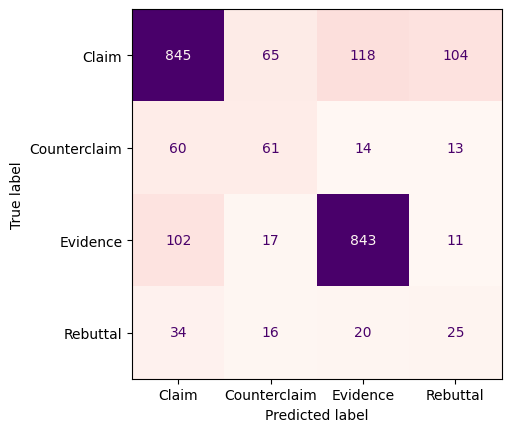

In [42]:
cmd = ConfusionMatrixDisplay(cm, display_labels = list(LE.classes_))
cmd.plot(cmap = 'RdPu', colorbar = False)

# Baştan sona topic, opinion ve conclusion tahmini

Bu pipeline ile test setinden random bir topic seçiliyor, bu topic değerine en yakın 5 opinion bulunuyor ve bunların type değerleri tahmin ediliyor (Claim,Rebuttal...) daha sonra huggingface üzerindeki bir summarizer modeli ile metin özetleniyor. Özetler gene benzer bir şekilde cosine_similarity ölçüm metriği ile değerlendirildi.

*Bu noktada elbette opinion type ları opinion değerleri ile birlikte embedding edilip summarizer bu şekilde fine-tune edilirse çok daha doğru sonuçlar bulunabilir. ([CLAIM_] gibi type bilgisi içeren tokenlar eklenmesi)*

In [43]:
def create_end2end_test_example_pipeline():
    # test setinden random bir idx (0-303) üretme
    idx = np.random.randint(0,np.random.randint(0,len(test_similar_opinions)))
    print("TEST topic_id : ", test_conclusions.iloc[idx].topic_id)
    
    # test topiclerine en yakın 5 opinion ve type değerleri
    the_closest_opinions = test_similar_opinions[idx]
    types = test_similar_opinions_types[idx]
    
    # opinion type tahmini
    test_seq = TOKENIZER.texts_to_sequences(the_closest_opinions)
    test_pad = pad_sequences(test_seq, maxlen = MAX_LENGTH)       

    pred_exp = model.predict(test_pad, verbose = 0)
    pred_exp = np.argmax(pred_exp, axis = 1)


    print(Fore.RED + "\nPREDICT OPINION TYPE: \t",[LE.classes_[type_] for type_ in pred_exp])
    print(Fore.GREEN + "\nORIGINAL OPINION TYPE: \t",[LE.classes_[type_] for type_ in types])
    print(Style.RESET_ALL)
    print("---"*40)
    
    # en yakın 5 cümleyi birleştirip bir paragraf yapma
    final_paragraph = ''
    for i in range(len(the_closest_opinions)):
        final_paragraph = final_paragraph + ' ' + the_closest_opinions[i]
    
    # huggingface summarizer
    pred_summary = (summarizer(final_paragraph, max_length = 100, min_length = 20, do_sample=False))[0]['summary_text']
    print(Fore.RED + "\nPREDICT SUMMARY:", pred_summary)
    
    org_summary = test_conclusions.iloc[idx].text
    print(Fore.GREEN +"\nORIGINAL SUMMARY:", org_summary)
    print(Style.RESET_ALL)
    print("---"*40)
    
    # tahmin edilen summary için cosine_similarity değeri
    pred_summary_emb = model_for_similarity_emmedding.encode(pred_summary, show_progress_bar = False)
    org_summary_emb = model_for_similarity_emmedding.encode(org_summary,  show_progress_bar = False)
    sim = cosine_similarity(pred_summary_emb.reshape(1,-1), org_summary_emb.reshape(1,-1))[0]
    print("SUMMARY SIMILARITY :{0:.3f}".format(sim[0]))

In [44]:
create_end2end_test_example_pipeline()

Your max_length is set to 100, but your input_length is only 74. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=37)


TEST topic_id :  44A5406282B8

PREDICT OPINION TYPE: 	 ['Counterclaim', 'Claim', 'Evidence', 'Claim', 'Claim']

ORIGINAL OPINION TYPE: 	 ['Claim', 'Claim', 'Evidence', 'Claim', 'Claim']

------------------------------------------------------------------------------------------------------------------------

PREDICT SUMMARY: Hearing many different sides help come better conclusion weigh pros cons situation seeking one opinion something help make best choices respectful others, also help future. opinions, narrow opinions few. then, compare opinions yours. that, make better decision. provided one two opinions leads able decifer right wrong next move is.

ORIGINAL SUMMARY: people seek multiple opinions many reasons. ones mentioned ones find important people.

------------------------------------------------------------------------------------------------------------------------
SUMMARY SIMILARITY :0.507


In [45]:
create_end2end_test_example_pipeline()

Your max_length is set to 100, but your input_length is only 51. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=25)


TEST topic_id :  45D156498F73

PREDICT OPINION TYPE: 	 ['Claim', 'Claim', 'Claim', 'Claim', 'Claim']

ORIGINAL OPINION TYPE: 	 ['Claim', 'Claim', 'Claim', 'Claim', 'Claim']

------------------------------------------------------------------------------------------------------------------------

PREDICT SUMMARY:  getting multiple opinions helps making decision. Getting multiple opinions help make better choice helping make decision. seeking multiple opinions may open new possibilities considered.

ORIGINAL SUMMARY: many important decisions make life. order make best choice, consider many opinions. say people experience you, everyone different opinion, compare opinions. point view always going best point view. said, seek multiple points views, knowledge make best choice possible.

------------------------------------------------------------------------------------------------------------------------
SUMMARY SIMILARITY :0.575


In [46]:
create_end2end_test_example_pipeline()

Your max_length is set to 100, but your input_length is only 64. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=32)


TEST topic_id :  A737705B81A4

PREDICT OPINION TYPE: 	 ['Claim', 'Evidence', 'Claim', 'Evidence', 'Claim']

ORIGINAL OPINION TYPE: 	 ['Evidence', 'Claim', 'Claim', 'Claim', 'Claim']

------------------------------------------------------------------------------------------------------------------------

PREDICT SUMMARY:  seeking multiple opinions always keep mind would beneficial making certain choice. asking opinion might want ask one person person ask might better advice person. asking multiple opinion's actually help lot.

ORIGINAL SUMMARY: people may gave good advice. seeking multiple opinions one person help make better choice

------------------------------------------------------------------------------------------------------------------------
SUMMARY SIMILARITY :0.744


In [51]:
create_end2end_test_example_pipeline()

TEST topic_id :  5173FB3C75A9

PREDICT OPINION TYPE: 	 ['Claim', 'Evidence', 'Claim', 'Evidence', 'Evidence']

ORIGINAL OPINION TYPE: 	 ['Claim', 'Evidence', 'Claim', 'Evidence', 'Evidence']

------------------------------------------------------------------------------------------------------------------------

PREDICT SUMMARY: Technology proven unhealthy adults especially teenagers. rotted brains, shortened attention span, removed creativity. generation revolved around technology, set stage future. coming school sitting classroom, phones zipped backpacks laptops shut.

ORIGINAL SUMMARY: social skills, resources, good relationships, students likely achieve goals. without things, long distance learning students set behind outside world. therefore, students attend school traditional way obtain benefits opportunities successful can.

------------------------------------------------------------------------------------------------------------------------
SUMMARY SIMILARITY :0.275


In [67]:
# tüm test test_conclusions
def convert_opinion_similarities_to_paragraph(similar_opinions, conclusions_df):
    pred_summaries = []
    cosine_similarities = []
    paragraphs = []

    for i in range(conclusions_df.shape[0]):
        true_summary = conclusions_df.iloc[i]['text']
        
        # en yakın 5 cümlenin toplanarak bir paragraf yapılması
        final_paragraph = ' '
        for j in range(len(similar_opinions[i])):
            final_paragraph = final_paragraph + ' ' +similar_opinions[i][j]
        paragraphs.append(final_paragraph)

        # summarization
        pred_summary = (summarizer(final_paragraph, max_length = 100, min_length = 20, do_sample=False))[0]['summary_text']
        
        pred_summary_emb = model_for_similarity_emmedding.encode(pred_summary, show_progress_bar = False)
        true_summary_emb = model_for_similarity_emmedding.encode(true_summary,  show_progress_bar = False)
        sim = cosine_similarity(pred_summary_emb.reshape(1,-1), true_summary_emb.reshape(1,-1))[0]
        
        pred_summaries.append(pred_summary)
        cosine_similarities.append(sim)
        
    final_df = conclusions_df.copy()
    final_df['pred_conclusion'] = pred_summaries
    final_df['conc_cos_similarity'] = cosine_similarities
    final_df['paragraphs'] = paragraphs
    return final_df

In [55]:
# nihai test_conclusion tahminleri ve sonuçları
test_final_pred_df = convert_opinion_similarities_to_paragraph(test_similar_opinions, test_conclusions)

Your max_length is set to 100, but your input_length is only 69. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=34)
Your max_length is set to 100, but your input_length is only 74. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=37)
Your max_length is set to 100, but your input_length is only 88. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=44)
Your max_length is set to 100, but your input_length is only 72. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=36)
Your

In [72]:
# pragraphs -> en yakın 5 opinion birleştirilerek oluşturulan test paragrafları
# pred_conclusion -> facebook/bart-large-cnn modeli ile yapılan summarizationlar
# conc_cos_similarity -> pred summary ve true text(summary) cosine similarity değerleri

test_final_pred_df.head()

,id,topic_id,text,type,effectiveness,pred_conclusion,conc_cos_similarity,paragraphs
0,fbf59f6078bc,22D938F5E0E2,way successors achieve three skills easily att...,Concluding Statement,Adequate,Home school gives students time focus needs wa...,[0.5636822],im sure students benefitfrom home school ano...
1,a34a9f3afd16,233A35247566,differences education makes beautiful. every p...,Concluding Statement,Effective,Students benefit attending class online work p...,[0.6854257],"secondly, students benefit attending class o..."
2,25bdf4857ab4,23C6ED53A179,reasons believe asking multiple people advice ...,Concluding Statement,Effective,People face difficult decisions choices often ...,[0.65141857],people face difficult decisions choices ofte...
3,26e009aa129e,242E9BA55C0C,distance learning exciting innovative form lea...,Concluding Statement,Effective,Students would benefit able attend classes hom...,[0.70987123],students would benefit able attend classes h...
4,11ecfbee48b1,2446D9BE78B8,"evidence suggests, taking advice multiple peop...",Concluding Statement,Effective,Getting advice from multiple people can help p...,[0.7685499],getting multiple opinions could help someone...


In [71]:
test_final_pred_df.to_csv('test_final_pred_df_p.csv', index = False)